# Example queries for Housing Characteristics on COVID-19 Knowledge Graph
[Work in progress]

This notebook demonstrates how to run Cypher queries to get [Housing Characteristics from the American Community Survey 2018 5-year data](https://data.census.gov/cedsci/table?tid=ACSDP5Y2018.DP04) at multiple levels of geographic granularity. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

## Housing Characteristics
The following variables are available for queries. Variable names ending with Pct represent values in percent, whereas all other variables represent counts. For details see [Subject Definitions](https://www2.census.gov/programs-surveys/acs/tech_docs/subject_definitions/2018_ACSSubjectDefinitions.pdf).

             # ROOMS
             'DP04_0037E': 'medianRoomsInHousingUnit',
             
             # HOUSING TENURE
             'DP04_0046E': 'ownerOccupiedHousingUnits',
             'DP04_0046PE': 'ownerOccupiedHousingUnitsPct',
             'DP04_0047E': 'renterOccupiedHousingUnits',
             'DP04_0047PE': 'renterOccupiedHousingUnitsPct',
             'DP04_0048E': 'averageHouseholdSizeOfOwnerOccupiedUnit',
             'DP04_0049E': 'averageHouseholdSizeOfRenterOccupiedUnit',
    
             # VEHICLES AVAILABLE
             'DP04_0057E': 'occupiedHousingUnitsWithVehicles',
             'DP04_0058E': 'occupiedHousingUnitsNoVehicles',
             'DP04_0058PE': 'occupiedHousingUnitsNoVehiclesPct',
    
             # OCCUPANTS PER ROOM
             Note, the following variables contain special characters and need to be 
             quoted by backticks in Cypher queries (see examples below)
             'DP04_0077E': 'occupantsPerRoom1.00orLess',
             'DP04_0077PE': 'occupantsPerRoom1.00orLessPct',
             'DP04_0078E': 'occupantsPerRoom1.01to1.50',
             'DP04_0078PE': 'occupantsPerRoom1.01to1.50Pct',
             'DP04_0079E': 'occupantsPerRoom1.51orMore',
             'DP04_0079PE': 'occupantsPerRoom1.51orMorePct'

## Geographic granularity
Data are available at 3 levels of granularity:
* US County
* US Zip Code
* US Census Tract

## Query Examples

### Get Data By US County

If the state and county fips codes are available, housing characteristics can be retrieved directly.

Note, fips codes are represented as strings.

##### Example: Average household size

In [4]:
state_fips = '06'
county_fips = '073'

In [5]:
query = """
MATCH (h:Housing{countyFips:$county_fips, stateFips:$state_fips})
RETURN h.stateFips, h.countyFips, 
       h.averageHouseholdSizeOfOwnerOccupiedUnit, h.averageHouseholdSizeOfRenterOccupiedUnit
       
"""
df = graph.run(query, county_fips=county_fips, state_fips=state_fips).to_data_frame()
df.head()

,h.stateFips,h.countyFips,h.averageHouseholdSizeOfOwnerOccupiedUnit,h.averageHouseholdSizeOfRenterOccupiedUnit
0,06,073,2.9,2.83


Example: Get the same data by traversing the KG

In [6]:
county = 'Los Angeles County'

In [7]:
query = """
MATCH (a:Admin2{name:$admin2})-[:HAS_HOUSING]-(h:Housing)
RETURN a.name, h.stateFips, h.countyFips, 
       h.averageHouseholdSizeOfOwnerOccupiedUnit, h.averageHouseholdSizeOfRenterOccupiedUnit
"""
df = graph.run(query, admin2=county).to_data_frame()
df.head()

,a.name,h.stateFips,h.countyFips,h.averageHouseholdSizeOfOwnerOccupiedUnit,h.averageHouseholdSizeOfRenterOccupiedUnit
0,Los Angeles County,06,037,3.19,2.84


### Get Data by US Postal Code

Note, postal codes are represented as strings.

In [8]:
zip_code = '92130'

In [9]:
query = """
MATCH (h:Housing{postalCode: $zip_code})
RETURN h.postalCode, h.ownerOccupiedHousingUnitsPct, h.renterOccupiedHousingUnitsPct
"""
df = graph.run(query, zip_code=zip_code).to_data_frame()
df.head()

,h.postalCode,h.ownerOccupiedHousingUnitsPct,h.renterOccupiedHousingUnitsPct
0,92130,66.5,33.5


##### Example: List occupands per room for Zip codes with a place name

Note, Zip code areas may cross city boundaries. Place names are the preferred names used by the US Postal Service.

In [10]:
place_name = 'Chula Vista'

query = """
MATCH (p:PostalCode{placeName:$place_name})-[:HAS_HOUSING]-(h:Housing)
RETURN p.name AS `Zip code`, 
       h.`occupantsPerRoom1.00orLessPct` AS `1.00 or less`,
       h.`occupantsPerRoom1.01to1.50Pct` AS  `1.01 to 1.50`,
       h.`occupantsPerRoom1.51orMorePct` AS `1.51 or more`
"""
df = graph.run(query, place_name=place_name).to_data_frame()
df.head()

,Zip code,1.00 or less,1.01 to 1.50,1.51 or more
0,91910,88.9,7.6,3.5
1,91911,85.8,8.8,5.3
2,91913,93.9,4.7,1.4
3,91914,98.5,1.2,0.3
4,91915,96.5,2.9,0.6


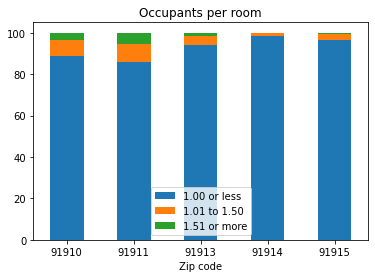

In [11]:
df.plot.bar(x='Zip code', 
            y=['1.00 or less', '1.01 to 1.50', '1.51 or more'], 
            title='Occupants per room', stacked=True, rot=0);

### Get Data by US Census Tract

Note, tracts are represented at strings.

##### Example: Occupants per room for a tract

In [12]:
tract = '06073008324'

In [13]:
query = """
MATCH (h:Housing{tract: $tract})
RETURN h.tract,
       h.`occupantsPerRoom1.00orLessPct` AS `1.00 or less`,
       h.`occupantsPerRoom1.01to1.50Pct` AS  `1.01 to 1.50`,
       h.`occupantsPerRoom1.51orMorePct` AS `1.51 or more`
"""
df = graph.run(query, tract=tract).to_data_frame()
df.head()

,h.tract,1.00 or less,1.01 to 1.50,1.51 or more
0,06073008324,100.0,0.0,0.0


##### Example: List occupants per from for all tracts in a county

In [14]:
state = 'California'
county = 'Orange County'

query = """
MATCH (a1:Admin1{name: $admin1})-[:IN]-(a2:Admin2{name: $admin2})-[:IN]-(t:Tract)-[:HAS_HOUSING]-(h:Housing)
RETURN a1.name AS State, a2.name AS County, t.name AS Tract,
       h.`occupantsPerRoom1.00orLessPct` AS `1.00 or less`,
       h.`occupantsPerRoom1.01to1.50Pct` AS  `1.01 to 1.50`,
       h.`occupantsPerRoom1.51orMorePct` AS `1.51 or more`
"""
df = graph.run(query, admin1=state, admin2=county).to_data_frame()
df.head()

,State,County,Tract,1.00 or less,1.01 to 1.50,1.51 or more
0,California,Orange County,06059062625,96.5,2.0,1.6
1,California,Orange County,06059062614,96.9,1.7,1.4
2,California,Orange County,06059032061,97.3,1.3,1.4
3,California,Orange County,06059110109,96.3,1.9,1.8
4,California,Orange County,06059110001,97.3,2.7,0.0
